In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import kagglehub
import joblib
import networkx as nx
from tqdm import tqdm
from  sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import swifter



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [199]:
#  pip install kagglehub
# %pip install tqdm

In [200]:
# # Download latest version
# path = kagglehub.dataset_download("kazanova/sentiment140")

# print("Path to dataset files:", path)

<!-- <p style="color: lightblue;">Sentiment labeling in the dataset:</p>
<ul>
  <li>0 = negative</li>
  <li>2 = neutral</li>
  <li>4 = positive</li>
</ul> -->
Sentiment labeling in the dataset:
- 0 = negative
- 2 = neutral
- 4 = positive

In [201]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [203]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

We then create another dataframe where it only have the columns we will be using :

In [204]:
df_cleaned = df[['sentiment', 'text']]
df_cleaned.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We will map the labels (0 = negative, 1 = positive)

In [205]:
df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)
df_cleaned

C:\Users\dell\AppData\Local\Temp\ipykernel_21956\3272369782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Let's check the distribution of sentiments:

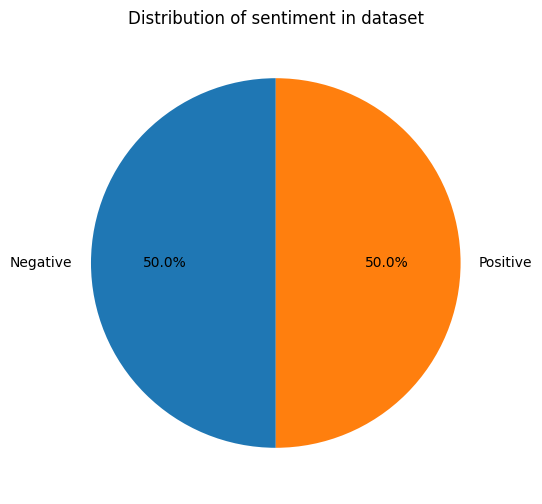

In [206]:

# Pie chart
# Count sentiment values, ensuring no NaNs or invalid entries
sentiment_counts = df_cleaned['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

# Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

As we can see there is a balance between positive and negative sentiment.

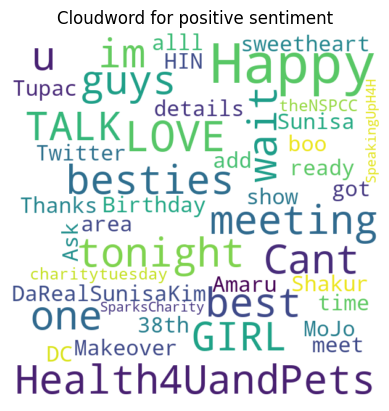

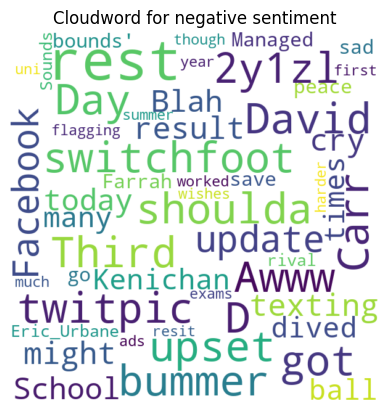

In [194]:
from wordcloud import STOPWORDS
text_positive = str(df_cleaned[df_cleaned['sentiment'] == 1]['text'].values)
text_negative = str(df_cleaned[df_cleaned['sentiment'] == 0]['text'].values)

def plot_word_cloud(text,desc) :


    wc = WordCloud(width=600,height=600,background_color="white", max_words=200, stopwords=STOPWORDS,  max_font_size=90,collocations = False, random_state=42)

    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cloudword for {desc}")
    plt.show()

plot_word_cloud(text_positive, "positive sentiment")
plot_word_cloud(text_negative, "negative sentiment")

# Preprocessing

In [210]:
class TextPreprocessor:
    def __init__(self):
        # Initialize the word lemmatizer and the emojis dictionary
        self.word_lemmatizer = WordNetLemmatizer()
        self.emojis = {
            ':)': 'smile',
             ':-)': 'smile',
             ';d': 'wink',
             ':-E': 'vampire',
             ':(': 'sad',

            ':-(': 'sad',
             ':-<': 'sad',
             ':P': 'raspberry',
             ':O': 'surprised',

            ':-@': 'shocked',
             ':@': 'shocked',
            ':-$': 'confused',
             ':\\': 'annoyed',

            ':#': 'mute',
             ':X': 'mute',
             ':^)': 'smile',
             ':-&': 'confused',
             '$_$': 'greedy',

            '@@': 'eyeroll',
             ':-!': 'confused',
             ':-D': 'smile',
             ':-0': 'yell',
             'O.o': 'confused',

            '<(-_-)>': 'robot',
             'd[-_-]b': 'dj',
             ":'-)": 'sadsmile',
             ';)': 'wink',
             ';D': 'wink',

            ';-)': 'wink',
             'O:-)': 'angel',
            'O*-)': 'angel',
            '(:-D': 'gossip',
             '=^.^=': 'cat',
             ':D':'smile',
            ':\\': 'annoyed',
        }

    def clean_text(self, text):
        """Cleaning text from unwanted elements"""
        # Remove URLs
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # Remove @username
        text = re.sub(r'@\w+', '', text).strip()
        # Remove email addresses
        text = re.sub(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', '', text)
        # Remove quoted text
        text = re.sub(r'["\'].*?["\']', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove "etc."
        text = re.sub(r'\betc\.?\b', '', text, flags=re.IGNORECASE)
        return text

    def extract_features(self, text):
        """
        Extract features: link, mail, quote, etc...
        """
        return {
            'links': len(re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', text)),
            'emails': len(re.findall(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', text)),
            'quotes': len(re.findall(r'["\'].*?["\']', text)),
            'hashtags': len(re.findall(r'#\w+', text)),
            'etc_count': len(re.findall(r'\betc\.?\b', text, flags=re.IGNORECASE)),
            'nb_caracter': len(text)
        }

    def lemmatize_text(self, text):
        """
        Lemmatize the words in the text.
        """
        processed_text = []
        for word in text.split():
            if len(word) > 1:
                lemmatized_word = self.word_lemmatizer.lemmatize(word)
                processed_text.append(lemmatized_word)
        return ' '.join(processed_text)

    def handle_emojies(self, text):
        """Replace emojis with text"""
        for emoji, meaning in self.emojis.items():
            text = text.replace(emoji, "EMOJI_" + meaning)
        return text

    def preprocess(self, text):
        """
        Preprocess using all the previous functions
        """
        cleaned_text = self.clean_text(text)
        replace_emojie = self.handle_emojies(cleaned_text)
        lemmatized_text = self.lemmatize_text(replace_emojie)
        features = self.extract_features(text)
        return lemmatized_text, features


In [211]:
preprocessor = TextPreprocessor()

# sample_text = "@user Check out this amazing link: https://example.com #awesome etc. 'Quoted text' email@example.com :D"

# cleaned_text, features = preprocessor.preprocess(sample_text)

# print("Cleaned Text:", cleaned_text)
# print("Features:", features)

df_cleaned['cleaned_text'], df_cleaned['features'] = zip(*df_cleaned['text'].swifter.apply(preprocessor.preprocess))

features_df = pd.DataFrame(df_cleaned['features'].tolist())
df_cleaned = pd.concat([df_cleaned, features_df], axis=1).drop('features', axis=1)


# last time run : 11m 46s
# last time run : 13m 9s
# last time tun : 16m 4s


Pandas Apply:   0%|          | 0/1600000 [00:00<?, ?it/s]

In [209]:
df_cleaned.head()

,sentiment,text,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","/2y1zl Awww, that's bummer. You shoulda got Da...",1,0,0,0,0,115
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,0,0,0,0,0,111
2,0,@Kenichan I dived many times for the ball. Man...,dived many time for the ball. Managed to save ...,0,0,0,0,0,89
3,0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire,0,0,0,0,0,47
4,0,"@nationwideclass no, it's not behaving at all....","no, itm mad. why am here? because can't see yo...",0,0,1,0,0,111


# TF-IDF

In [ ]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), max_features=50000)
batch_size = 10000
for i in tqdm(range(0, len(df_cleaned), batch_size), desc='Batch processing'):
    batch = df_cleaned.cleaned_text[i:i + batch_size]
    tfidf_matrix= tfidf.fit_transform(batch)